This example examines output from the `blob2d` example included in the `BOUT-dev` repo. \[It was tested with output from the `next` branch at commit 999793fe363e062fd47da20bcd8ff679c85a8b30\].

`blob2d` is a simplified model of an isolated 'blob' or 'filament'. These are coherent, field-aligned structures that are common in the scrape-off layer of tokamaks. `blob2d` represents the evolution only in the plane perpendicular to the magnetic field, with approximate closures describing parallel currents to the sheath and loss of density due to parallel flows. The 'blob' is created by initialising the simulation with a Gaussian density perturbation on a constant background.

You can use it in two ways, either generate the data or download it. Generate by running `blob2d` (with the command `./blob2d -d delta_1` to produce output in the delta_1 directory as used in this example) and then copying its `BOUT.inp` (input file), and `BOUT.dmp.*.nc` (output files) to the directory containing this notebook. Download by running the first Python cell in the 'Setup' section.

Contents:
* Setup
* Load
* Plot
* Animate
* Analyse

Setup
=====

In [1]:
# Download data files if you do not have them already
from pathlib import Path
import urllib.request
for filename in ["BOUT.inp", "BOUT.dmp.0.nc"]:
    if not Path(filename).exists():
        urllib.request.urlretrieve(f"https://zenodo.org/record/4298582/files/{filename}?download=1", filename)

In [2]:
# set up matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 14})

In [3]:
import numpy as np
from xbout import open_boutdataset

Load
====

First we need to open the Dataset.

The chunks argument to `open_boutdataset()` is needed so that dask can parallelise
operations over the time dimension (by default the chunk size is the size of the
arrays in the files being loaded). See
http://xarray.pydata.org/en/stable/dask.html#chunking-and-performance.

Note: a warning from `open_boutdataset()` is expected. For `blob2d` the z-direction
is a periodic, binormal direction with lengths normalised to the background hybrid
gyro-radius `rho_s=sqrt(T_e/m_i)`, rather than the usual toroidal angle. `'dz'` is
used and `'ZMIN'` and `'ZMAX'` are ignored.

In [4]:
ds = open_boutdataset(chunks={"t": 4})

# Use squeeze() to get rid of the y-dimension, which has length 1 as blob2d does not
# simulate the parallel dimension.
ds = ds.squeeze(drop=True)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:   (t: 51, x: 260, y: 1, z: 256)
Coordinates:
  * t         (t) float64 0.0 50.0 100.0 150.0 ... 2.4e+03 2.45e+03 2.5e+03
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 252 253 254 255 256 257 258 259
  * y         (y) float64 0.5
  * z         (z) float64 0.0 0.3 0.6 0.9 1.2 1.5 ... 75.3 75.6 75.9 76.2 76.5
Data variables:
    dx        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    dy        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g11       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g22       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g33       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g12       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g13       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g23       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.n

/home/jomotani/soltransport/pylib/xbout/xbout/load.py:248: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")
/home/jomotani/soltransport/pylib/xbout/xbout/geometries.py:151: UserWarning: Size of toroidal domain as calculated from nz*dz (76.8 is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


We choose to create a 'coordinate' for the x-dimension from `dx`.
This is not done generically because `dx` can have two-dimensional dependence
\- as well as varying radially it can be different e.g. in core and PF regions.
However, for a slab geometry like `blob2d`, `dx` is a constant so it can easily
be used to create a one-dimensional x-coordinate.
This ensures we get a sensible aspect ratio in plots.
A z-coordinate was already created from `dz`, because `dz` is always a scalar,
so it can always be used to create a 1d 'dimension coordinate'.

In [5]:
dx = ds["dx"].isel(x=0).values

# Get rid of existing "x" coordinate, which is just the index values.
ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

Plot
===

Here we use xarray methods to plot simple slices.

First make some plots of the initial state

In [6]:
ds_initial = ds.isel(t=0)

<IPython.core.display.Javascript object>


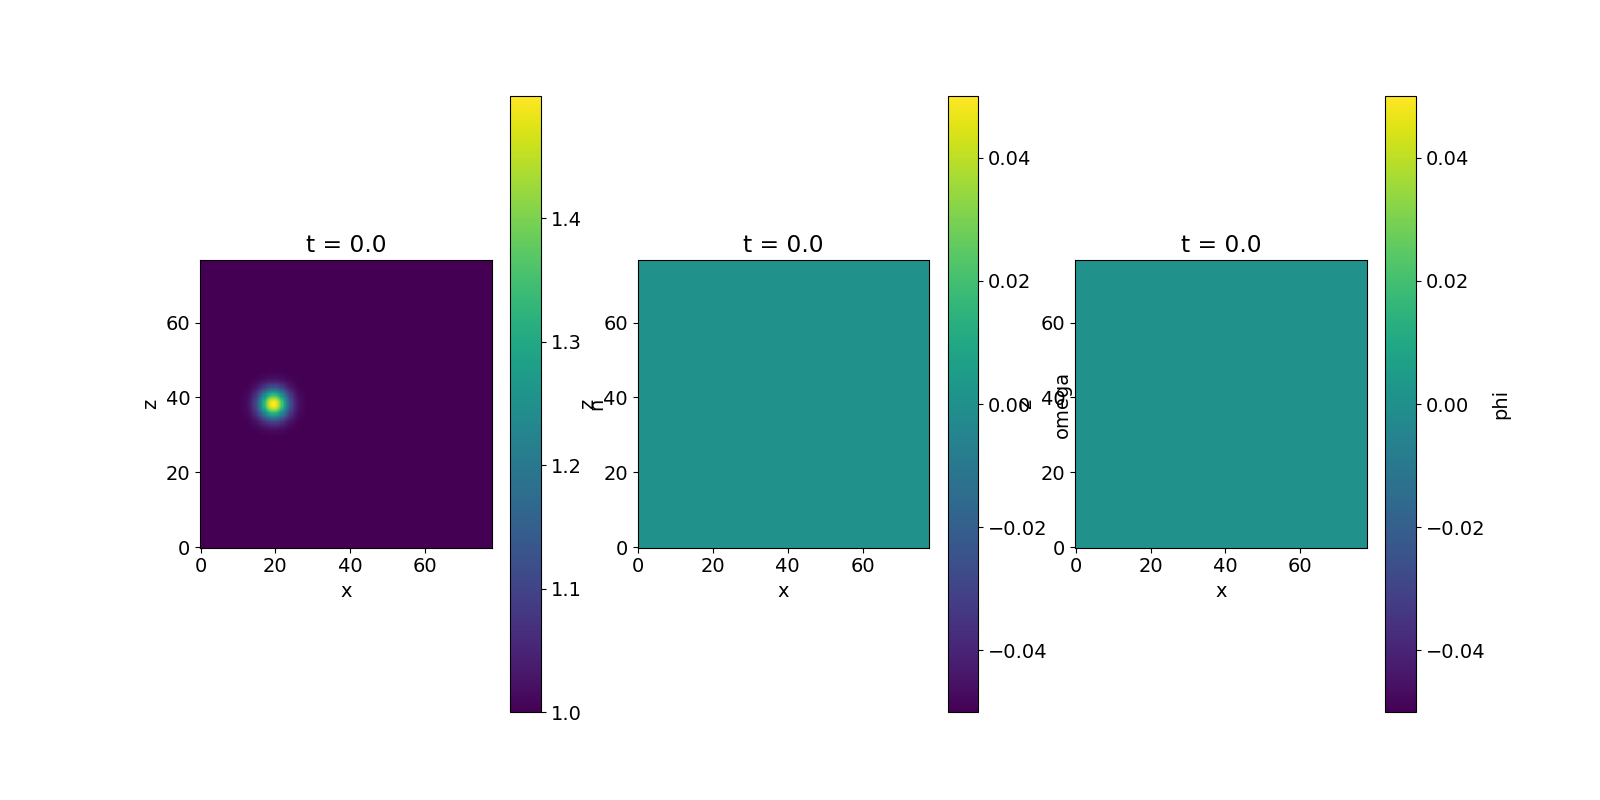

In [7]:
plt.figure()
ax = plt.subplot(131)
ax.set_aspect("equal")
ds_initial["n"].plot(x="x", y="z")
ax = plt.subplot(132)
ax.set_aspect("equal")
ds_initial["omega"].plot(x="x", y="z")
ax = plt.subplot(133)
ax.set_aspect("equal")
ds_initial["phi"].plot(x="x", y="z")

Plots at a time point during the blob evolution

<IPython.core.display.Javascript object>


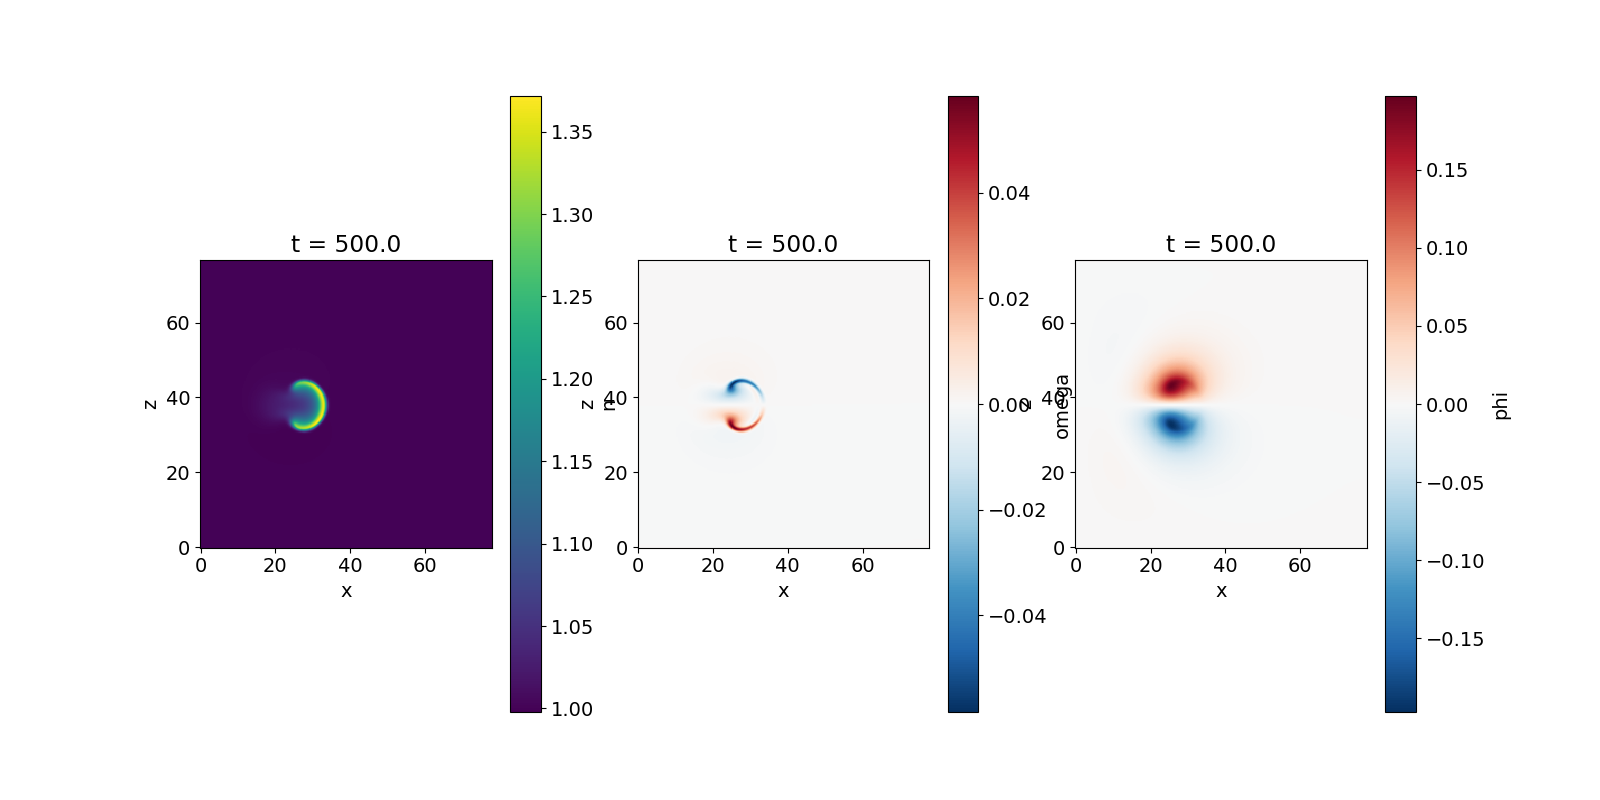

In [8]:
tind = 10

# Uses xarray methods to plot simple slices
plt.figure()
ax = plt.subplot(131)
ax.set_aspect("equal")
ds.isel(t=tind)["n"].plot(x="x", y="z")
ax = plt.subplot(132)
ax.set_aspect("equal")
ds.isel(t=tind)["omega"].plot(x="x", y="z")
ax = plt.subplot(133)
ax.set_aspect("equal")
ds.isel(t=tind)["phi"].plot(x="x", y="z")

Slicing to a 1d Dataset automatically produces a 1d plot, here
a radial density profile through the blob centre

<IPython.core.display.Javascript object>


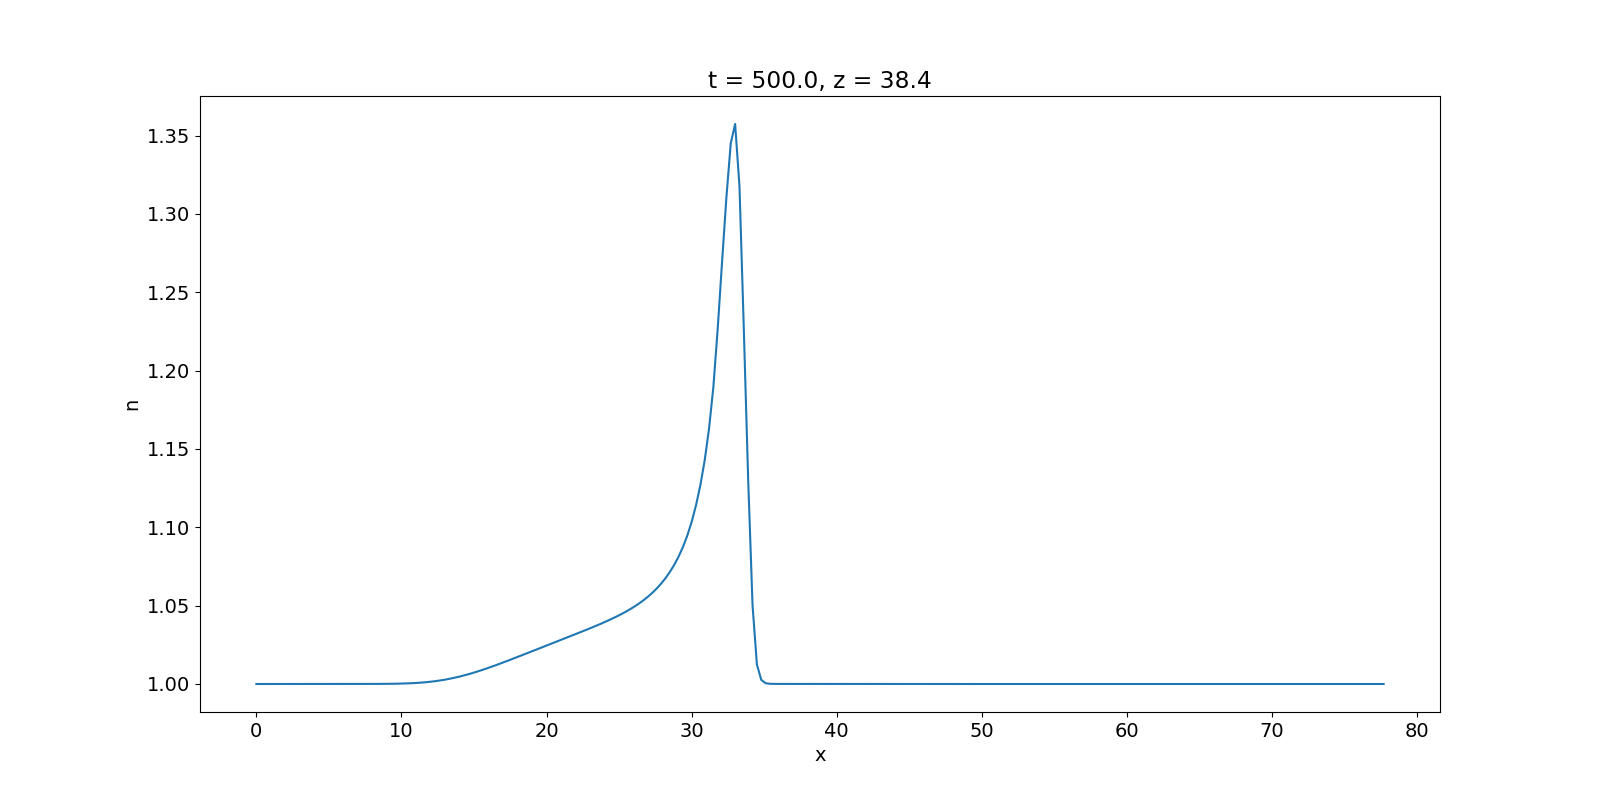

In [9]:
plt.figure()
ds.isel(t=10, z=128)["n"].plot()

Animate
=======

Use `xbout` methods through the `.bout` accessor to create animations.

For a DataArray

In [ ]:
ds["n"].bout.animate2D(aspect="equal")

Animate several fields from a Dataset with `animate_list()`

In [ ]:
ds.bout.animate_list(["n", "omega", "phi"], ncols=3, aspect="equal")

DataArray objects can be passed to `animate_list()` (as long as
they all have the same time-axis length), e.g. to combine 1d
and 2d plots.

Keyword arguments to `animate_list()` can be passed lists (with
as many entries as variables being plotted), to set a per-variable
value.

Animations can be saved by passing a 'save_as' argument giving a name
for the output file, producing a .gif file.

In [ ]:
ds.bout.animate_list(["n", "omega", "phi", ds["n"].isel(z=128)], aspect=["equal", "equal", "equal", "auto"], save_as="blob")

Analyse
=======

Perform some analysis of the blob to demonstrate more `xarray` methods.

Find the centre-of mass of the blob using `.integrate()` ([documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.integrate.html)).

<IPython.core.display.Javascript object>


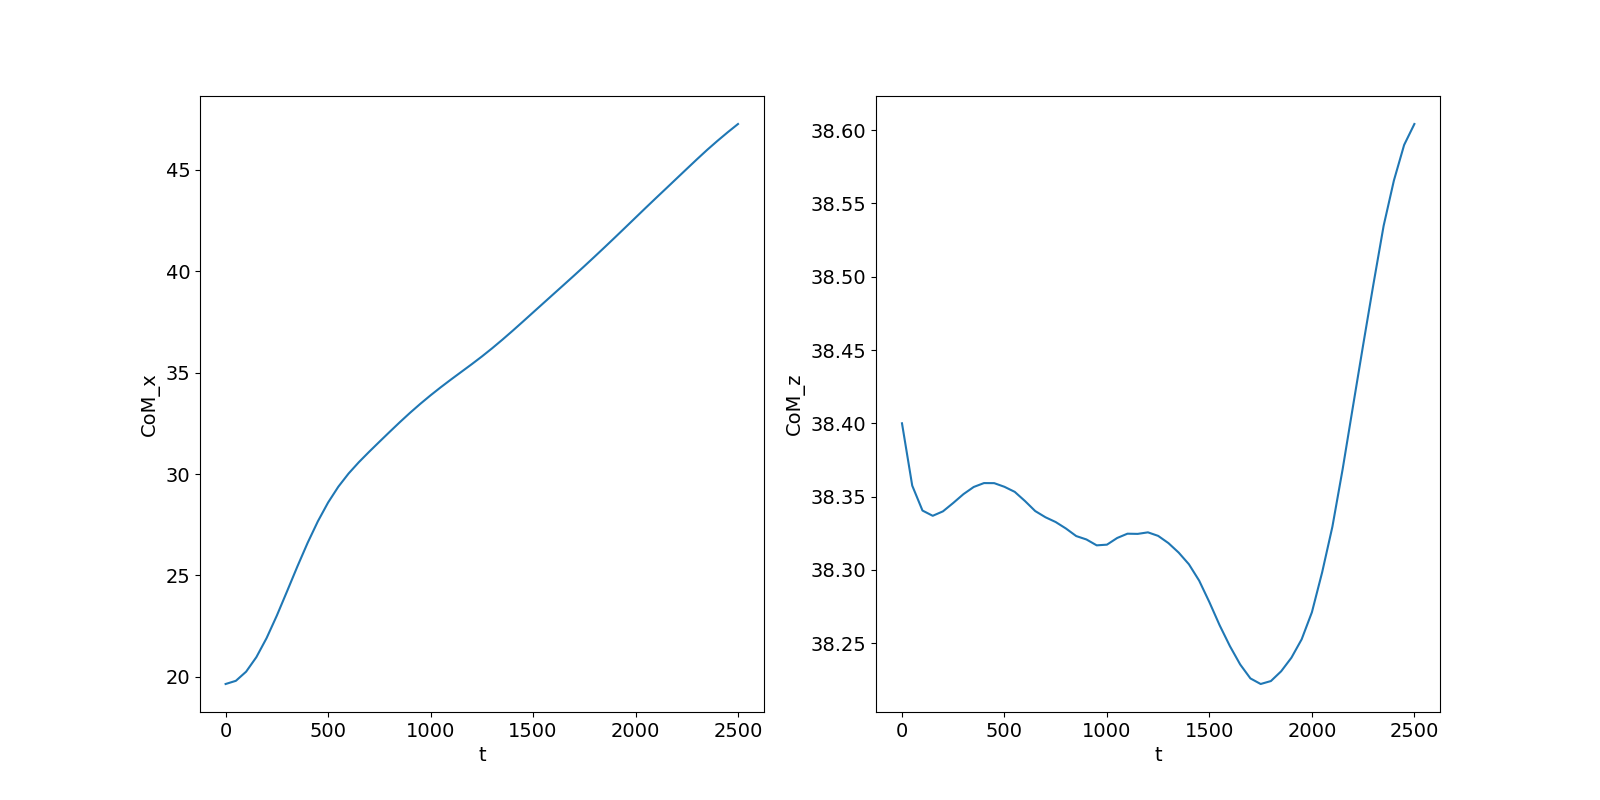

In [10]:
background_density = 1.0
delta_n = ds["n"] - background_density
integrated_density = delta_n.integrate(dim=["x", "z"])
ds["CoM_x"] = (ds["x"]*delta_n).integrate(dim=["x", "z"]) / integrated_density
ds["CoM_z"] = (ds["z"]*delta_n).integrate(dim=["x", "z"]) / integrated_density

plt.figure()
plt.subplot(121)
ds["CoM_x"].plot()
plt.subplot(122)
ds["CoM_z"].plot()

Find the blob velocity using `.differentiate()` ([documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.differentiate.html)).

This is a somewhat crude method, using finite difference on the output timestep.
It would be more accurate to calculate and integrate the ExB velocity.

<IPython.core.display.Javascript object>


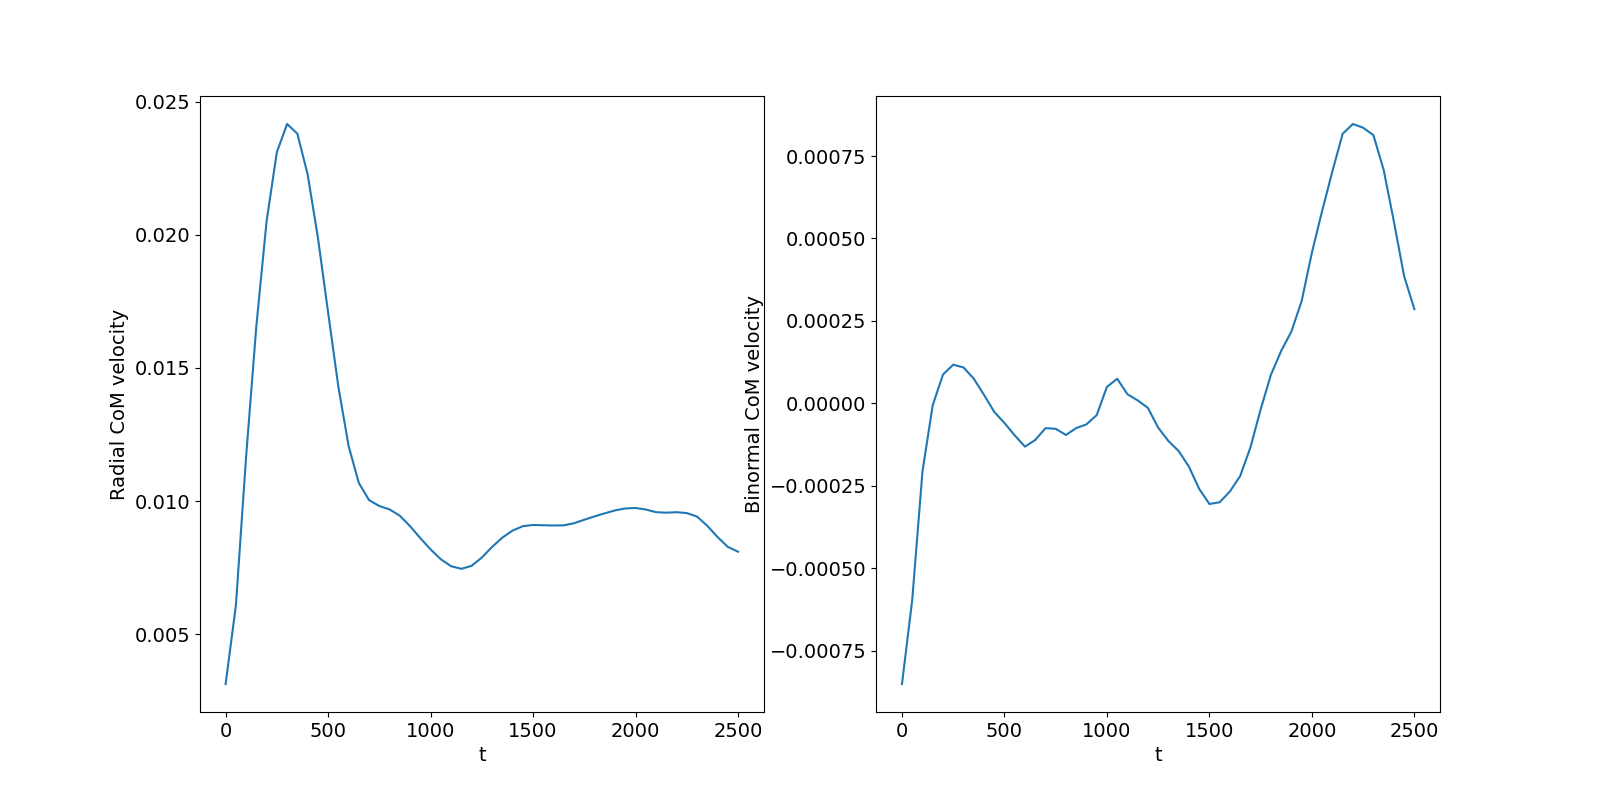

Text(0, 0.5, 'Binormal CoM velocity')

In [11]:
v_x = ds["CoM_x"].differentiate("t")
v_z = ds["CoM_z"].differentiate("t")

plt.figure()
plt.subplot(121)
v_x.plot()
plt.ylabel("Radial CoM velocity")
plt.subplot(122)
v_z.plot()
plt.ylabel("Binormal CoM velocity")